In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from als_factorization import *
from time import time
import seaborn as sns
%matplotlib inline

### Loading and preparing data

In [2]:
data = pd.read_csv('datasets/ml-100k/u.data', sep='\t', header=None)

data.columns = ['user_id', 'item_id', 'rating', 'timestamp']
R = data.pivot(index='user_id', columns='item_id', values='rating')
R = R.fillna(0)
R = sparse.csr_matrix(R.values)

data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: (80000, 4)
Test data shape: (20000, 4)


In [4]:
train_df = train_data.pivot(index='user_id', columns='item_id', values='rating')
test_df = test_data.pivot(index='user_id', columns='item_id', values='rating')

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

R_train = sparse.csr_matrix(train_df.values)
R_test = sparse.csr_matrix(test_df.values)

print(f"Training rating matrix shape: {R_train.shape}")
print(f"Sparsity: {R_train.nnz / (R_train.shape[0] * R_train.shape[1]):.4f}")

Training rating matrix shape: (943, 1653)
Sparsity: 0.0513


### Comparing parallel als factorization with the common one

In [5]:
from mp_als import *

n_factors = 100
lambda_reg = 0.1
n_iterations = 20

time_start = time()
U, V, _ = als_matrix_factorization(R, n_factors=n_factors, lambda_reg=lambda_reg, n_iterations=n_iterations, verbose=True)
time_taken_common_als = time() - time_start
print(f"Time taken for common ALS: {time_taken_common_als:.2f} seconds")

time_start = time()
U, V, _ = als_matrix_factorization_parallel(R, n_factors=n_factors, lambda_reg=lambda_reg, n_iterations=n_iterations, verbose=True)
time_taken_parallel_als = time() - time_start
print(f"Time taken for parallel ALS: {time_taken_parallel_als:.2f} seconds")

print(f"Speedup: {time_taken_common_als / time_taken_parallel_als:.2f}x")


Iteration 1/20 - RMSE: 0.5628
Iteration 2/20 - RMSE: 0.2580
Iteration 3/20 - RMSE: 0.1726
Iteration 4/20 - RMSE: 0.1334
Iteration 5/20 - RMSE: 0.1104
Iteration 6/20 - RMSE: 0.0952
Iteration 7/20 - RMSE: 0.0844
Iteration 8/20 - RMSE: 0.0761
Iteration 9/20 - RMSE: 0.0695
Iteration 10/20 - RMSE: 0.0641
Iteration 11/20 - RMSE: 0.0597
Iteration 12/20 - RMSE: 0.0559
Iteration 13/20 - RMSE: 0.0527
Iteration 14/20 - RMSE: 0.0499
Iteration 15/20 - RMSE: 0.0474
Iteration 16/20 - RMSE: 0.0452
Iteration 17/20 - RMSE: 0.0433
Iteration 18/20 - RMSE: 0.0416
Iteration 19/20 - RMSE: 0.0400
Iteration 20/20 - RMSE: 0.0385
Time taken for common ALS: 9.67 seconds
Iteration 1/20 - RMSE: 0.5628 - Time: 0.15s
Iteration 2/20 - RMSE: 0.2580 - Time: 0.13s
Iteration 3/20 - RMSE: 0.1726 - Time: 0.13s
Iteration 4/20 - RMSE: 0.1334 - Time: 0.12s
Iteration 5/20 - RMSE: 0.1104 - Time: 0.13s
Iteration 6/20 - RMSE: 0.0952 - Time: 0.12s
Iteration 7/20 - RMSE: 0.0844 - Time: 0.13s
Iteration 8/20 - RMSE: 0.0761 - Time: 0.1

### Grid Search Hyperparameters Tuning

In [6]:
param_grid = {
    'n_factors': [10, 20, 50, 100],
    'lambda_reg': [0.01, 0.1, 1.0],
    'n_iterations': [10, 20]
}

user_id_map = {id: i for i, id in enumerate(train_df.index)}
item_id_map = {id: i for i, id in enumerate(train_df.columns)}
reverse_item_id_map = {i: id for id, i in item_id_map.items()}

results = []

print("Starting hyperparameter grid search...")
for n_factors in param_grid['n_factors']:
    for lambda_reg in param_grid['lambda_reg']:
        for n_iterations in param_grid['n_iterations']:

            print(f"Training with n_factors={n_factors}, lambda_reg={lambda_reg}, n_iterations={n_iterations}")
            U, V, _ = als_matrix_factorization_parallel(R_train, n_factors, lambda_reg, n_iterations, verbose=False)
            train_rmse = calculate_rmse(R_train, U, V)
            test_rmse = evaluate_rmse(U, V, test_data, user_id_map, item_id_map)
            
            results.append({
                'n_factors': n_factors,
                'lambda_reg': lambda_reg,
                'n_iterations': n_iterations,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse
            })
            
            print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Starting hyperparameter grid search...
Training with n_factors=10, lambda_reg=0.01, n_iterations=10
Train RMSE: 0.6704, Test RMSE: 1.6623
Training with n_factors=10, lambda_reg=0.01, n_iterations=20
Train RMSE: 0.6563, Test RMSE: 1.6586
Training with n_factors=10, lambda_reg=0.1, n_iterations=10
Train RMSE: 0.6654, Test RMSE: 1.6588
Training with n_factors=10, lambda_reg=0.1, n_iterations=20
Train RMSE: 0.6529, Test RMSE: 1.6578
Training with n_factors=10, lambda_reg=1.0, n_iterations=10
Train RMSE: 0.6713, Test RMSE: 1.6675
Training with n_factors=10, lambda_reg=1.0, n_iterations=20
Train RMSE: 0.6649, Test RMSE: 1.6657
Training with n_factors=20, lambda_reg=0.01, n_iterations=10
Train RMSE: 0.5194, Test RMSE: 1.6482
Training with n_factors=20, lambda_reg=0.01, n_iterations=20
Train RMSE: 0.4929, Test RMSE: 1.6455
Training with n_factors=20, lambda_reg=0.1, n_iterations=10
Train RMSE: 0.5075, Test RMSE: 1.6435
Training with n_factors=20, lambda_reg=0.1, n_iterations=20
Train RMSE: 0.4


Best hyperparameters:
n_factors: 100.0
lambda_reg: 0.1
n_iterations: 20.0
Test RMSE: 1.5802
Train RMSE: 0.0165


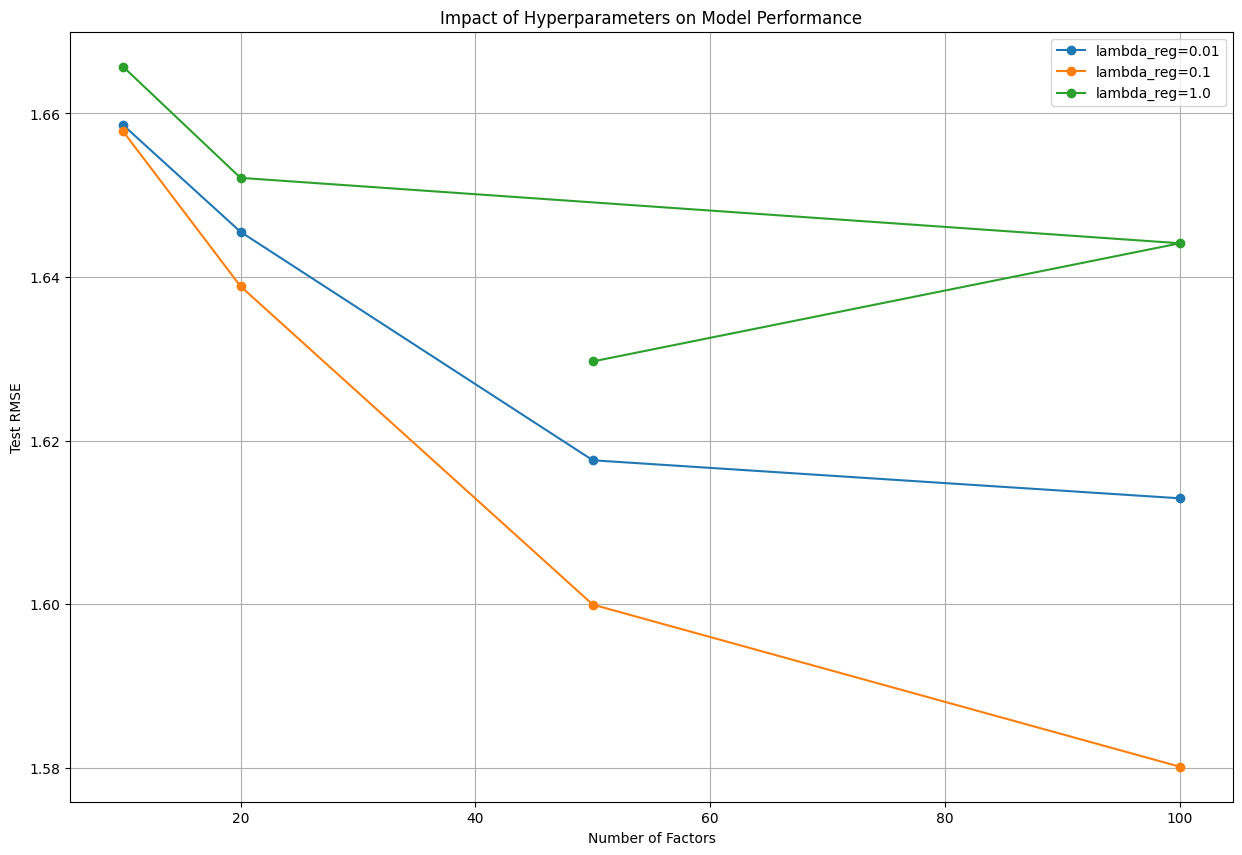

In [7]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_rmse')

print("\nBest hyperparameters:")
best_params = results_df.iloc[0]
print(f"n_factors: {best_params['n_factors']}")
print(f"lambda_reg: {best_params['lambda_reg']}")
print(f"n_iterations: {best_params['n_iterations']}")
print(f"Test RMSE: {best_params['test_rmse']:.4f}")
print(f"Train RMSE: {best_params['train_rmse']:.4f}")

plt.figure(figsize=(15, 10))

for lambda_reg in param_grid['lambda_reg']:
    subset = results_df[results_df['lambda_reg'] == lambda_reg]
    subset = subset[subset['n_iterations'] == param_grid['n_iterations'][-1]]  # Use max iterations
    plt.plot(subset['n_factors'], subset['test_rmse'], 
             marker='o', label=f'lambda_reg={lambda_reg}')

plt.xlabel('Number of Factors')
plt.ylabel('Test RMSE')
plt.title('Impact of Hyperparameters on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

best_n_factors = int(best_params['n_factors'])
best_lambda_reg = best_params['lambda_reg']
best_n_iterations = int(best_params['n_iterations'])

### Training best model on the full dataset

In [8]:
U, V, train_errors = als_matrix_factorization_parallel(R, best_n_factors, best_lambda_reg, best_n_iterations, verbose=True)

Iteration 1/20 - RMSE: 0.5628 - Time: 0.15s
Iteration 2/20 - RMSE: 0.2580 - Time: 0.15s
Iteration 3/20 - RMSE: 0.1726 - Time: 0.16s
Iteration 4/20 - RMSE: 0.1334 - Time: 0.14s
Iteration 5/20 - RMSE: 0.1104 - Time: 0.13s
Iteration 6/20 - RMSE: 0.0952 - Time: 0.13s
Iteration 7/20 - RMSE: 0.0844 - Time: 0.13s
Iteration 8/20 - RMSE: 0.0761 - Time: 0.14s
Iteration 9/20 - RMSE: 0.0695 - Time: 0.14s
Iteration 10/20 - RMSE: 0.0641 - Time: 0.14s
Iteration 11/20 - RMSE: 0.0597 - Time: 0.14s
Iteration 12/20 - RMSE: 0.0559 - Time: 0.13s
Iteration 13/20 - RMSE: 0.0527 - Time: 0.15s
Iteration 14/20 - RMSE: 0.0499 - Time: 0.15s
Iteration 15/20 - RMSE: 0.0474 - Time: 0.14s
Iteration 16/20 - RMSE: 0.0452 - Time: 0.14s
Iteration 17/20 - RMSE: 0.0433 - Time: 0.14s
Iteration 18/20 - RMSE: 0.0416 - Time: 0.14s
Iteration 19/20 - RMSE: 0.0400 - Time: 0.13s
Iteration 20/20 - RMSE: 0.0385 - Time: 0.13s


In [9]:
original_user_id = 4

if original_user_id in user_id_map:
    matrix_user_id = user_id_map[original_user_id]
    
    recommendations = recommend_items(matrix_user_id, U, V, R, top_n=10)
    
    print(f"Top 10 item recommendations for user {original_user_id}:")
    for i, (item_idx, pred_rating) in enumerate(recommendations):
        original_item_id = reverse_item_id_map[item_idx]
        print(f"{i+1}. Item {original_item_id}: Predicted rating = {pred_rating:.2f}")
else:
    print(f"User ID {original_user_id} not found in the dataset")

Top 10 item recommendations for user 4:
1. Item 1017: Predicted rating = 4.98
2. Item 90: Predicted rating = 4.96
3. Item 900: Predicted rating = 4.96
4. Item 83: Predicted rating = 4.95
5. Item 873: Predicted rating = 4.95
6. Item 297: Predicted rating = 4.94
7. Item 484: Predicted rating = 4.94
8. Item 431: Predicted rating = 4.94
9. Item 1177: Predicted rating = 4.94
10. Item 1049: Predicted rating = 4.94


In [10]:
def add_rating(user_id, item_ids, ratings, R):
    user_id = user_id_map[user_id]
    item_ids = [item_id_map[item_id] for item_id in item_ids]
    for item_id, rating in zip(item_ids, ratings):
        R[user_id, item_id] = rating
    U_updated, V_updated, _ = als_matrix_factorization_parallel(R, best_n_factors, best_lambda_reg, best_n_iterations, verbose=True)
    return U_updated, V_updated

In [11]:
def add_rating_optimized(user_id, item_ids, ratings, R):
    user_id = user_id_map[user_id]
    item_ids = [item_id_map[item_id] for item_id in item_ids]
    for item_id, rating in zip(item_ids, ratings):
        R[user_id, item_id] = rating
    U_updated= partial_als_matrix_factorization(user_id, R, U, V, lambda_reg)
    return U_updated

In [12]:
start_time = time()
U_updated, V_updated = add_rating(4, [318, 306, 172, 659, 292, 990], [1, 1, 1, 1, 1, 1], R)
time_taken_full_als = time() - start_time

/Users/narly/Code/projects/ALS-RecSys-for-movies/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Iteration 1/20 - RMSE: 0.5629 - Time: 0.16s
Iteration 2/20 - RMSE: 0.2580 - Time: 0.13s
Iteration 3/20 - RMSE: 0.1726 - Time: 0.14s
Iteration 4/20 - RMSE: 0.1333 - Time: 0.13s
Iteration 5/20 - RMSE: 0.1102 - Time: 0.14s
Iteration 6/20 - RMSE: 0.0950 - Time: 0.23s
Iteration 7/20 - RMSE: 0.0842 - Time: 0.12s
Iteration 8/20 - RMSE: 0.0760 - Time: 0.13s
Iteration 9/20 - RMSE: 0.0695 - Time: 0.13s
Iteration 10/20 - RMSE: 0.0642 - Time: 0.15s
Iteration 11/20 - RMSE: 0.0598 - Time: 0.14s
Iteration 12/20 - RMSE: 0.0560 - Time: 0.17s
Iteration 13/20 - RMSE: 0.0527 - Time: 0.15s
Iteration 14/20 - RMSE: 0.0499 - Time: 0.15s
Iteration 15/20 - RMSE: 0.0474 - Time: 0.14s
Iteration 16/20 - RMSE: 0.0452 - Time: 0.15s
Iteration 17/20 - RMSE: 0.0432 - Time: 0.15s
Iteration 18/20 - RMSE: 0.0414 - Time: 0.15s
Iteration 19/20 - RMSE: 0.0398 - Time: 0.18s
Iteration 20/20 - RMSE: 0.0384 - Time: 0.16s


In [13]:

start_time = time()
U_updated_optimized = add_rating_optimized(4, [318, 306, 172, 659, 292, 990], [1, 1, 1, 1, 1, 1], R)
time_taken_optimized_als = time() - start_time


Train Error: 0.04006392467991662


In [14]:
print(f"Time taken for full ALS: {time_taken_full_als:.2f} seconds")
print(f"Time taken for optimized ALS: {time_taken_optimized_als:.2f} seconds")
print(f"Speedup: {time_taken_full_als / time_taken_optimized_als / best_n_iterations:.2f}x")

Time taken for full ALS: 3.95 seconds
Time taken for optimized ALS: 0.03 seconds
Speedup: 5.83x


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2

def get_recommendations(user_id, U, V, R, top_n=10):
    matrix_user_id = user_id_map[user_id]
    recs = recommend_items(matrix_user_id, U, V, R, top_n=top_n)
    
    recommendations = []
    for item_idx, pred_rating in recs:
        original_item_id = reverse_item_id_map[item_idx]
        recommendations.append((original_item_id, pred_rating))
    
    return recommendations

full_als_recs = get_recommendations(original_user_id, U_updated, V, R, top_n=10)
optimized_als_recs = get_recommendations(original_user_id, U_updated_optimized, V, R, top_n=10)

comparison_df = pd.DataFrame({
    'Full ALS Movie ID': [rec[0] for rec in full_als_recs],
    'Full ALS Score': [rec[1] for rec in full_als_recs],
    'Optimized ALS Movie ID': [rec[0] for rec in optimized_als_recs],
    'Optimized ALS Score': [rec[1] for rec in optimized_als_recs]
})

comparison_df

,Full ALS Movie ID,Full ALS Score,Optimized ALS Movie ID,Optimized ALS Score
0,68,4.974767,693,4.940438
1,693,4.963706,68,4.937407
2,1017,4.963471,448,4.922109
3,13,4.957828,1017,4.920888
4,514,4.957492,900,4.917601
5,90,4.952437,83,4.915437
6,900,4.952161,136,4.890855
7,129,4.949385,1177,4.888610
8,297,4.945794,873,4.887021
9,136,4.945287,8,4.881286


##### Visualize the unique recommendations from each method

Movies unique to Full ALS recommendations:



,Movie ID,Predicted Rating,Rank
3,13,4.957828,4
1,514,4.957492,5
4,90,4.952437,6
0,129,4.949385,8
2,297,4.945794,9



Movies unique to Optimized ALS recommendations:



,Movie ID,Predicted Rating,Rank
0,448,4.922109,3
3,83,4.915437,6
4,1177,4.888610,8
2,873,4.887021,9
1,8,4.881286,10


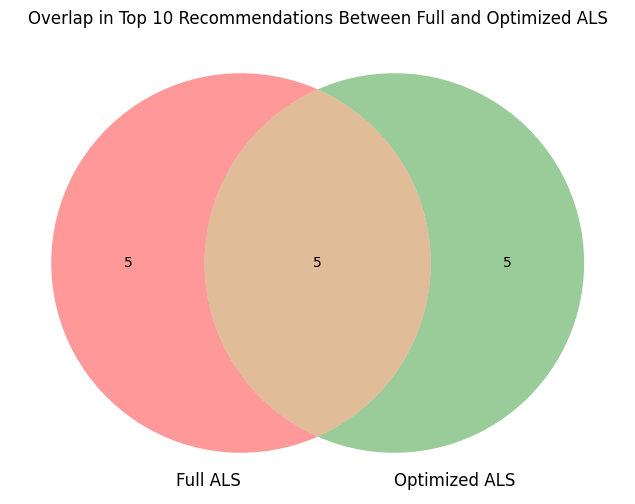

Jaccard Similarity: 0.33
Overlap Coefficient: 0.50
Number of common movies in top 10: 5


In [16]:

full_als_movie_ids = set([rec[0] for rec in full_als_recs])
optimized_als_movie_ids = set([rec[0] for rec in optimized_als_recs])
common_movies = full_als_movie_ids.intersection(optimized_als_movie_ids)
unique_to_full = full_als_movie_ids - optimized_als_movie_ids
unique_to_optimized = optimized_als_movie_ids - full_als_movie_ids

unique_full_movies = []
for movie_id in unique_to_full:
    rating = next(rec[1] for rec in full_als_recs if rec[0] == movie_id)
    rank = next(i+1 for i, rec in enumerate(full_als_recs) if rec[0] == movie_id)
    unique_full_movies.append({
        'Movie ID': movie_id,
        'Predicted Rating': rating,
        'Rank': rank
    })

unique_optimized_movies = []
for movie_id in unique_to_optimized:
    rating = next(rec[1] for rec in optimized_als_recs if rec[0] == movie_id)
    rank = next(i+1 for i, rec in enumerate(optimized_als_recs) if rec[0] == movie_id)
    unique_optimized_movies.append({
        'Movie ID': movie_id,
        'Predicted Rating': rating,
        'Rank': rank
    })

unique_full_df = pd.DataFrame(unique_full_movies).sort_values('Rank')
unique_optimized_df = pd.DataFrame(unique_optimized_movies).sort_values('Rank')

print(f"Movies unique to Full ALS recommendations:\n")
if len(unique_full_df) > 0:
    display(unique_full_df)
else:
    print("None")
    
print(f"\nMovies unique to Optimized ALS recommendations:\n")
if len(unique_optimized_df) > 0:
    display(unique_optimized_df)
else:
    print("None")

try:
    from matplotlib_venn import venn2
    plt.figure(figsize=(10, 6))
    venn2([full_als_movie_ids, optimized_als_movie_ids], 
         set_labels=('Full ALS', 'Optimized ALS'))
    plt.title('Overlap in Top 10 Recommendations Between Full and Optimized ALS')
    plt.show()
except ImportError:
    print("matplotlib-venn not installed. Install with: pip install matplotlib-venn")

jaccard_similarity = len(common_movies) / len(full_als_movie_ids.union(optimized_als_movie_ids))
overlap_coefficient = len(common_movies) / min(len(full_als_movie_ids), len(optimized_als_movie_ids))

print(f"Jaccard Similarity: {jaccard_similarity:.2f}")
print(f"Overlap Coefficient: {overlap_coefficient:.2f}")
print(f"Number of common movies in top 10: {len(common_movies)}")